<a href="https://colab.research.google.com/github/drscook/m5364_19fl_Data_Mining1/blob/master/DM2/hwk/m5365_20sp_hwk03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Math 5365 - Data Mining 2

Spring 2020, Tarleton State University

Dr. Scott Cook

Homework 03

Due 2020/02/24

# Goal: Extend prior Rudimentary Feedforward ANN code to handle classification.

We wrote "basic" code to do feedforward ANN with all continuous variables.  But to handle a categorical (nominal) target variable, we need to make some adjustments.
1. 1-hot encode the target variable -> if there are q levels, this gives q boolean indicator variables.  As a result, the output layer has contains q nodes.$\sum\limits_{j=1} A_{xj}$  $\displaystyle \sum_k{x}$

2. Use the "softmax" activation function in the output layer.  This is given by $y_{ij} = \frac{e^{x_{ij}}}{\sum\limits_{k}{e^{x_{ik}}}}$.  Softmax generalizes the logistic/sigmoid function to the case of more than 2 values, but introduces complexity (see below).

3. Use the cross-entropy cost function.
  - Let $y^*_{ij}$ denote the "true" value for row $i$ (1-hot encoded)
    - $y^*_{ij}=1$ means row $i$ is actually class $j$
    - $y^*_{ij}=0$ means row $i$ is actually NOT class $j$
  - Let $\hat{y}_{ij}$ denote the predicted value for row $i$ (ie. the output from node $j$ of the output layer $L$ for row $i$)
    - $\hat{y}_{ij}=0.37$ means the model assigns a 37\% probability that row $i$ is class $j$
  - The cross-entropy cost function is $C=\sum\limits_{i,j} y^*_{ij} log(\hat{y}_{ij})$.

Complexities:
- Must code the cross-entropy cost function and its derivative.  Recall that $y^*_{ij}$ are *constants* because they are numbers from the given dataset; the variables are $\hat{y}_{ij}$.  This is relatively easy.
- Must code the softmax activation functino and its derivative.  This is more challenging, for the following reason.

In previous activation functions, $y_{lij}$ depended only on the single variable  $x_{lij}$.  Thus
$$\frac{\partial y_{l_1 i_i j_1}}{\partial x_{l_2 i_2 j_2}} = 0$$
unless all corresponding indices were equal ($l_1=l_2, i_1=i_2, j_1=j_2$).
Thus
$$\frac{\partial C}{\partial x_{lik}} = \frac{\partial C}{\partial y_{lik}} \frac{\partial y_{lik}}{\partial x_{lik}}$$
Thus, we could "cheat" and define the array DYDX to contain only the non-zero derivatives.  In code, this meant DYDX had shape $(n,p_l)$ and DCDX = DCDY * DYDX (elementwise)$

But, for softmax, $y_{lij} = \frac{e^{x_{lij}}}{\sum\limits_{k}{e^{x_{lik}}}}$.  Note that $y_{lij}$ is a function of all $x_{li0}, x_{li1}, \dots, x_{lip_l}$, so that
$$\frac{\partial y_{lij}}{\partial x_{lik}} \neq 0$$
In other words, indices 1 \& 2 must still match (as before), but index 3 can now differ.  As a result
$$\frac{\partial C}{\partial x_{lik}} = \sum\limits_{j}\frac{\partial C}{\partial y_{lij}} \frac{\partial y_{lij}}{\partial x_{lik}}$$

The code effect is that DYDX must now have shape $(n,p_l,p_l)$ and DCDX involves the corresponding np.einsum using DCDY and DYDX.

Now, we must recall some calculus to compute  $\frac{\partial y_{lij}}{\partial x_{lik}}$.  Let $Z_{li} = \sum\limits_{k}{e^{x_{lik}}}$ and note that $\frac{\partial Z_{li}}{\partial x_{lik}} = e^{x_{lik}}$ because all terms where $j \neq k$ vanish.  Return to the definition of softmax $y_{ij} = \frac{e^{x_{ij}}}{\sum\limits_{k}{e^{x_{ik}}}} = \frac{e^{x_{ij}}}{Z_{li}}$ and use the quotient rule.



## Your assignment

I have tried to implement all of this into the prior code.  But it doesn't work.  I can't find the problem.  It is probably a code bug, but there is a non-zero chance I have a deeper misunderstanding.  Your job is to try to fix it and tell me what I have screwed up.

I have been using https://www.deeplearningbook.org/contents/mlp.html as a guide.

The first cell is the code base.

The second cell is the same example used in the first generation of this code.  You can see that it does still work.

The third cell creates colored Gaussian clusters.  It is a simple toy dataset to use for debugging the code.  You can see the the cost goes *UP*, rather than down, eventually producing nan's (I assume to do overflow in np.exp).


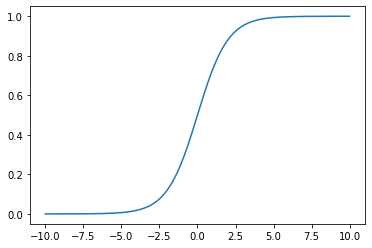

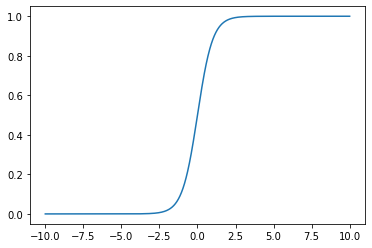

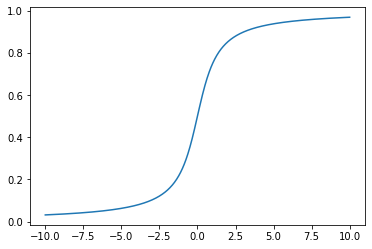

In [4]:
## Define functions for later use

import numpy as np
import matplotlib.pyplot as plt
import itertools as it


def min_max_scale(y):
    """min-max-scaler"""
    a = np.min(y)
    r = np.max(y) - a
    def scaler(y):
        return (y - a) / r
    def unscaler(z):
        return z * r + a
    return scaler, unscaler

# reshapes dy as needed
def DYDX_reshaper(DYDX):
    """
    To incorporate softmax, backprop now expects DYDX to be shape (n,pl,pl);
    it expected (n,pl) before.  This function reshapes (n,pl) to (n,pl,pl).
    """
    n, p = DYDX.shape
    return np.eye(p) * DYDX[...,np.newaxis]  # reshape DYDX to (n,p,p)

# common activation functions and their derivatives
def id():
    def f(X):
        return X.copy()
    def df(X):
        DYDX = np.ones_like(X)
        return DYDX_reshaper(DYDX)
    return f, df

def relu():
    def f(X):
        Y = X.copy()
        Y[Y<0] = 0.0
        return Y
    def df(X):
        DYDX = (X>0).astype(float)
        return DYDX_reshaper(DYDX)
    return f, df

def sigmoid():
    def f(X):
        return 1 / (1 + np.exp(-X))
    def df(X):
        DYDX = np.exp(-X) / (1 + np.exp(-X))**2
        return DYDX_reshaper(DYDX)
    return f, df

def tanh():
    def f(X):
        Y = np.tanh(X)  # range is [-1, 1]
        return Y / 2 + 1 / 2  # scales so range is [0,1]
    def df(X):
        DYDX = 1 - np.tanh(X)**2  # derivative of tanh
        DYDX /= 2 # scaling factor from above
        return DYDX_reshaper(DYDX)
    return f, df

def arctan():
    def f(X):
        Y = np.arctan(X)  # range is [-pi/2, pi/2]
        return Y / np.pi + 1/2  # scales so range is [0,1]
    def df(X):
        DYDX = 1 / (1 + X**2)  # derivative of arctan
        DYDX /= np.pi  # scaling factor from above
        return DYDX_reshaper(DYDX)
    return f, df

def softmax():
    """
    My attempt at softmax.  The bug may lie in here.
    """
    def f(X):
        Z = np.exp(X)
        return Z / Z.sum(axis=1, keepdims=True)
    def df(X):
        n, p = X.shape
        E = np.exp(X)
        Z = E.sum(axis=1)
        R = np.einsum('ij, ik -> ijk', E, E)  # "right" numerator term of DYDX
        D = R * np.eye(p)  # Should set all terms when j!=k to 0
        L = np.einsum('ijk, i -> ijk', D, Z)  # "left" numerator term of DYDM
        return (L - R) / (Z**2)[:, np.newaxis, np.newaxis]
    return f, df


def mse_cost():
    def f(pred, true):
        e = pred - true
        return (e**2).sum() / (2 * n)
    def df(pred, true):
        e = pred - true
        return e / n
    return f, df


def cross_entropy_cost():
    def f(pred, true):
        e = - true * np.log(pred)
        return e.sum()
    def df(pred, true):
        return - true / pred
    return f, df


def setup_ANN():
    n, p = feat.shape
    m, q = targ.shape
    if m != n:
        raise Exception('feat and targ must have the same number of rows')

    nodes = [p] + hidden_nodes + [q]
    L = len(nodes)

    f, df = activation()
    f = [f for l in range(L)]
    df = [df for l in range(L)]
    f[0], df[0] = id()

    X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX = pre_allocate(n, nodes)
    return n, p, m, q, nodes, L, f, df, X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX


def pre_allocate(n, nodes):
    ## pre-allocate variables

    ## X[l,i,j] = input to node j of layer l for observation i; X[l] has shape (n, nodes[l])
    X = [np.zeros(shape=[n,p]) for p in nodes]

    ## DCDX[l,i,j] = partial derivative of cost wrt X[l,i,j]; DCDX[l] has shape (n, nodes[l])
    DCDX = [np.zeros_like(x) for x in X]

    ## Y[l,i,j] = output from node j of layer l for observation i; Y[l] has shape (n, nodes[l])
    Y = [np.zeros(shape=[n,p]) for p in nodes]

    ## DCDY[l,i,j] = partial derivative of cost wrt Y[l,i,j]; DCDY[h] has shape (n, nodes[l])
    DCDY = [np.zeros_like(y) for y in Y]

    ## B[l,k] = bias into node k of layer l+1; B[l] has shape nodes[l+1]
    # B = [rnd.rand(p) for p in nodes[1:]]
    B = [np.zeros(p) for p in nodes[1:]]

    ## DCDB[l,k] = partial derivative of cost wrt B[l,k]; DCDB[l] has shape nodes[l+1]
    DCDB = [np.zeros_like(b) for b in B]
    
    ## W[l,j,k] = weight of edge from node j of layer l to node k of layer l+1; W[l] has shape (nodes[l], nodes[l+1])
    W_sh = [(i,o) for (i,o) in zip(nodes[:-1], nodes[1:])]  ## Generate shapes for W
    W = [rnd.uniform(-1, 1, s) for s in W_sh]  # fill with uniformly random weights in [-1,1]
    
    ## DCDW[l,j,k] = partial derivative of cost wrt W[l,j,k]; DCDW[l] has shape (nodes[l], nodes[l+1])
    DCDW = [np.zeros_like(w) for w in W]

    ## DYDX[l,i,j,k] = partial derivative of Y[l,i,j] wrt X[l,i,k]; DYDX[l] has shape (n, nodes[l], nodes[l])
    DYDX = [np.zeros(shape=[n,p,p]) for p in nodes]

    return X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX


def train_ANN(X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX):
    cost_hist = []
    for step in range(max_steps):
        X[0] = feat.copy()
        forward_propagate(X, Y)
        C = cost(Y[-1], targ)
        cost_hist.append(C)
        if step % report_period == 0:
            print(f"step {step} cost = {C}")

        DCDY[-1] = dcost(Y[-1], targ)
        backward_propagate(DCDX, DCDY, DCDB, DCDW, DYDX)
        descend_gradient(B, W)
    return cost_hist


def forward_propagate(X, Y):
    for l in range(L-1):
        Y[l] = f[l](X[l])
        X[l+1] = Y[l] @ W[l] + B[l]
    l += 1
    Y[l] = f[l](X[l])


def backward_propagate(DCDX, DCDY, DCDB, DCDW, DYDX):
    for l in reversed(range(L-1)):
        DYDX[l+1] = df[l+1](X[l+1])
        DCDX[l+1] = np.einsum('ij, ijk -> ik', DCDY[l+1], DYDX[l+1])
        DCDY[l]   = np.einsum('ik, jk  -> ij', DCDX[l+1], W[l])
        DCDW[l]   = np.einsum('ik, ij  -> jk', DCDX[l+1], Y[l])
        DCDB[l]   = np.einsum('ik      -> k' , DCDX[l+1])
        

def descend_gradient(B, W):
    # Compute magnitude of gradient - square all entries of DCDB & DCDW, add, sqrt
    # We must do list comprehension over each layer b/c layers are not the same size
    m = np.sqrt(np.sum([np.sum(B**2) + np.sum(W**2) for B,W in zip(DCDB, DCDW)]))
    for l in range(L-1):
        B[l] -= DCDB[l] / m * learn_rate
        W[l] -= DCDW[l] / m * learn_rate


# Verify that ranges of bounded activation functions really are [0,1]
x = np.linspace(-10,10,1000)
for f in [sigmoid, tanh, arctan]:
    plt.plot(x, f()[0](x))
    plt.show()

step 0 cost = 0.06249706116692326
step 10000 cost = 0.00027651037969071425


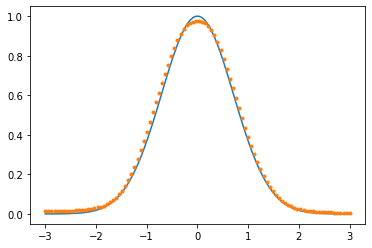

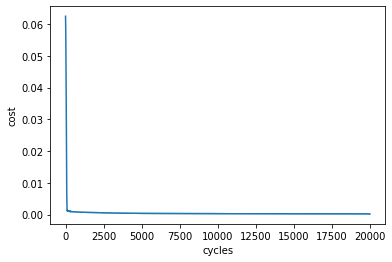

In [5]:
import numpy as np
import matplotlib.pyplot as plt
rnd = np.random.RandomState(42)


## make data
feat = np.sort(np.linspace(-3, 3, 100))[:, np.newaxis]
def f(x):
    return np.exp(-x**2)
y = f(feat)
y_scaler, y_unscaler = min_max_scale(y)
targ = y_scaler(y)



## Set Hyperparameters
hidden_nodes = [10,3] # list of node counts for each hidden layer

# activation = relu
activation = sigmoid
# activation = tanh
# activation = arctan

cost, dcost = mse_cost()

max_steps = 20000
learn_rate = 0.1
report_period = 10000



## Setup & Train ANN
n, p, m, q, nodes, L, f, df, X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX = setup_ANN()
cost_hist = train_ANN(X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX)


## Results
fig = plt.plot()
plt.plot(feat, targ)
plt.plot(feat, Y[-1], '.')
plt.show()


fig, ax = plt.subplots()
ax.plot(cost_hist)
ax.set_xlabel('cycles')
ax.set_ylabel('cost')
plt.show()

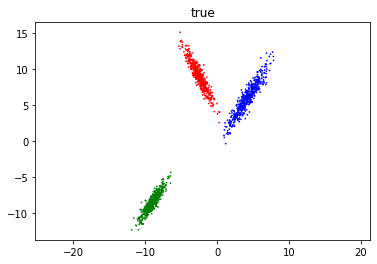

step 0 cost = 2400.46568871963
step 100 cost = 12291.668548196767
step 200 cost = 25225.97934940647
step 300 cost = 37971.041613520654
step 400 cost = 50567.39565471477
step 500 cost = 63111.78877792643
step 600 cost = 75636.18488120059
step 700 cost = 88151.99849176744
step 800 cost = 100663.94129983959
step 900 cost = 113174.25170911718
step 1000 cost = 125684.18693846458
step 1100 cost = 138194.66516329543
step 1200 cost = nan
step 1300 cost = nan
step 1400 cost = nan
step 1500 cost = nan
step 1600 cost = nan
step 1700 cost = nan
step 1800 cost = nan
step 1900 cost = nan
[ True  True  True ... False False False]


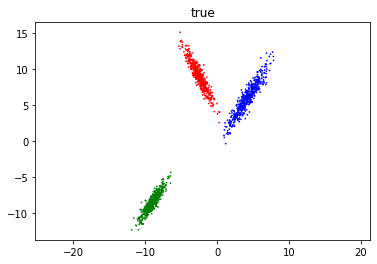

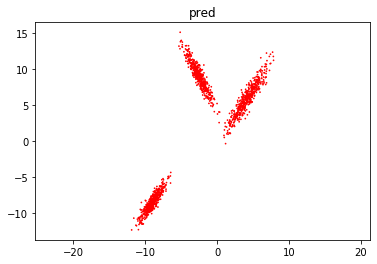

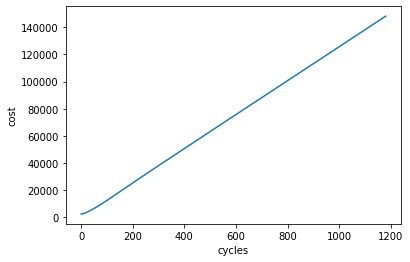

In [8]:
import numpy as np
import matplotlib.pyplot as plt
rnd = np.random.RandomState(42)


## make data
p = 2  # dimension
clrs = np.array(['red', 'blue', 'green'])
nl = 500  # samples for each color (level)

q = len(clrs)  # colors (levels)
n = q * nl  # samples total

feat = np.zeros((n, p), dtype='float')
targ = np.zeros((n, q), dtype='int')
targ_clr = np.full(n, None)

i = 0
separation_factor = 10
tightness_factor = 2

for c, clr in enumerate(clrs):
    mu  = separation_factor * rnd.uniform(-1, 1, p) # center for cluster
    cov = tightness_factor  * rnd.uniform(-1, 1, (p, p))  # covariance matrix for cluster
    cov = cov @ cov.T  # make cov positive semi-definite
    z = rnd.multivariate_normal(mu, cov, nl)  # draw sample points
    feat[i:i+nl] = z  # record in feat
    targ_clr[i:i+nl] = clr  # record color
    targ[i:i+nl, c] = True  # 1-hot encode color
    i += nl

fig, ax = plt.subplots()
ax.scatter(*feat.T, c=targ_clr, s = 0.5)
ax.axis('equal')
ax.set_title('true')
plt.show()



## Set Hyperparameters
hidden_nodes = [5] # list of node counts for each hidden layer

# activation = relu
# activation = sigmoid
activation = tanh
# activation = arctan

cost, dcost = cross_entropy_cost()


max_steps = 2000
learn_rate = 0.1
report_period = 100



## Setup & Train ANN
n, p, m, q, nodes, L, f, df, X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX = setup_ANN()

f[-1], df[-1] = softmax()

cost_hist = train_ANN(X, DCDX, Y, DCDY, B, DCDB, W, DCDW, DYDX)

pred_clr = clrs[np.argmax(Y[-1], axis=1)]
correct = targ_clr == pred_clr
print(correct)

## Results
fig, ax = plt.subplots()
ax.scatter(*feat.T, c=targ_clr, s = 0.5)
ax.axis('equal')
ax.set_title('true')
plt.show()

fig, ax = plt.subplots()
ax.scatter(*feat.T, c=pred_clr, s = 0.5)
ax.axis('equal')
ax.set_title('pred')
plt.show()




fig, ax = plt.subplots()
ax.plot(cost_hist)
ax.set_xlabel('cycles')
ax.set_ylabel('cost')
plt.show()



In [0]:
## example from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/, use sigmoid, cost=(e**2)/2
%%time
rnd = np.random.RandomState(42)


## Set Hyperparameters
hidden_nodes = [2]  # list of node counts for each hidden layer
activation = sigmoid
learn_rate = 0.5
max_steps = 1
report_period = 1


## Get data
feat = np.array([[.05,.1]])
targ = np.array([[.01,.99]])


## Setup & Train ANN
n, p, m, q, nodes, L, cost, dcost, f, df, X, DCDX, Y, DCDY, B, DCDB, W, DCDW = setup_ANN()

## example from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/, use sigmoid activtion & square cost=(e**2)/(2n)
W = [np.array([[0.15, 0.25], [0.20, 0.30]]),
     np.array([[0.40, 0.50], [0.45, 0.55]])]

cost_hist = train_ANN(feat, targ, X, DCDX, Y, DCDY, B, DCDB, W, DCDW)


## Results
for l in range(L):
    print(f"layer = {l}")
    print("X")
    print(X[l])
    print("Y")
    print(Y[l])
    if l < L-1:
        print("W")
        print(W[l])
        print("B")
        print(B[l])

    print()

step 0 cost = 0.3218208039242589
layer = 0
X
[[0.05 0.1 ]]
Y
[[0.05 0.1 ]]
W
[[0.14886932 0.24894401]
 [0.19773864 0.29788801]]
B
[0.35192656 0.92959445]

layer = 1
X
[[0.40204012 0.99321431]]
Y
[[0.59917772 0.72972234]]
W
[[0.18975689 0.55535867]
 [0.1939506  0.61741983]]
B
[0.38110788 0.69104956]

layer = 2
X
[[1.30004008 1.29959463]]
Y
[[0.78584173 0.78576675]]

CPU times: user 6.22 ms, sys: 2.15 ms, total: 8.37 ms
Wall time: 6.87 ms
